In [11]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import cross_val_score
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('learning_set.csv')
df.head()

# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)


def objective(trial):
    params = {
    "iterations": trial.suggest_int("iterations", 100, 500),
    "depth": trial.suggest_int("depth", 4, 10),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
    "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
    "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0),
    "border_count": trial.suggest_int("border_count", 32, 255),
    #"scale_pos_weight": 24.25,  # zostawiamy tylko to!
    "verbose": 0,
    "loss_function": 'Logloss',
    "eval_metric": 'F1',
    "random_state": 42
    }

    model = CatBoostClassifier(**params, auto_class_weights='Balanced')
    f1 = cross_val_score(model, X_train, y_train, cv=3, scoring="f1").mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)


[I 2025-04-20 23:16:39,000] A new study created in memory with name: no-name-bcf8392f-909e-4c05-9e31-89d6bd688cc7
[I 2025-04-20 23:16:43,035] Trial 0 finished with value: 0.12763343657785525 and parameters: {'iterations': 185, 'depth': 4, 'learning_rate': 0.023632288791831865, 'l2_leaf_reg': 0.037438187063915246, 'bagging_temperature': 0.6567881665508999, 'random_strength': 3.1884006154992393, 'border_count': 236}. Best is trial 0 with value: 0.12763343657785525.
[I 2025-04-20 23:16:56,289] Trial 1 finished with value: 0.1276249973276283 and parameters: {'iterations': 387, 'depth': 5, 'learning_rate': 0.03351310989488424, 'l2_leaf_reg': 0.029541057557506686, 'bagging_temperature': 0.7099050619733643, 'random_strength': 9.0147245826828, 'border_count': 247}. Best is trial 0 with value: 0.12763343657785525.
[I 2025-04-20 23:17:12,384] Trial 2 finished with value: 0.12684101972865516 and parameters: {'iterations': 314, 'depth': 9, 'learning_rate': 0.03322640340724913, 'l2_leaf_reg': 1.519

Best parameters: {'iterations': 125, 'depth': 5, 'learning_rate': 0.17317625509125426, 'l2_leaf_reg': 1.5950277916611242, 'bagging_temperature': 0.6977994755891463, 'random_strength': 0.13646520024126596, 'border_count': 100}



🔍 Najlepszy threshold (na podstawie F1-score): 0.17
threshold    0.100000
precision    0.062500
recall       0.013785
f1           0.022588
Name: 0, dtype: float64


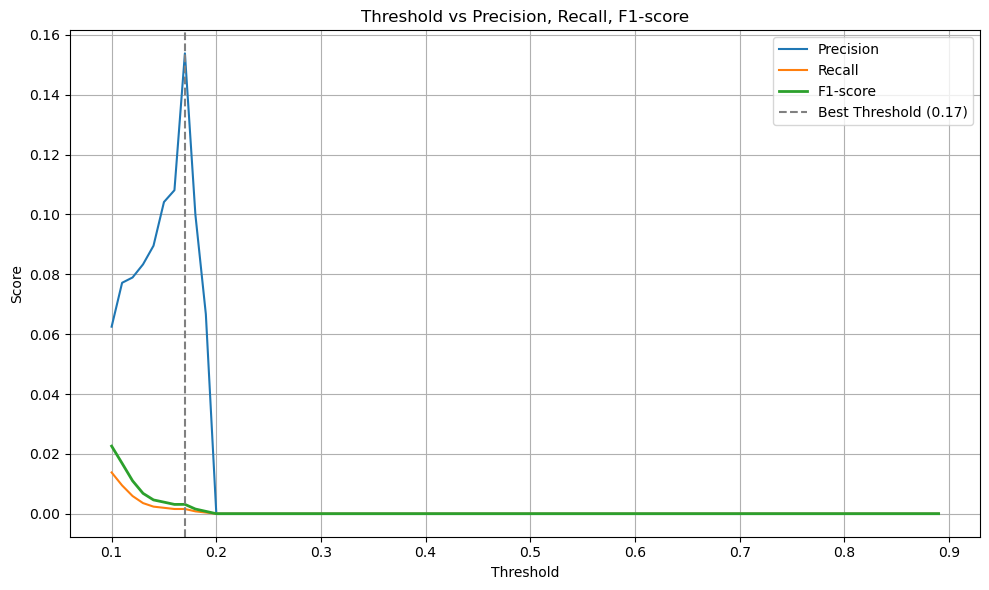

✅ Best threshold: 0.17 with precision: 0.094


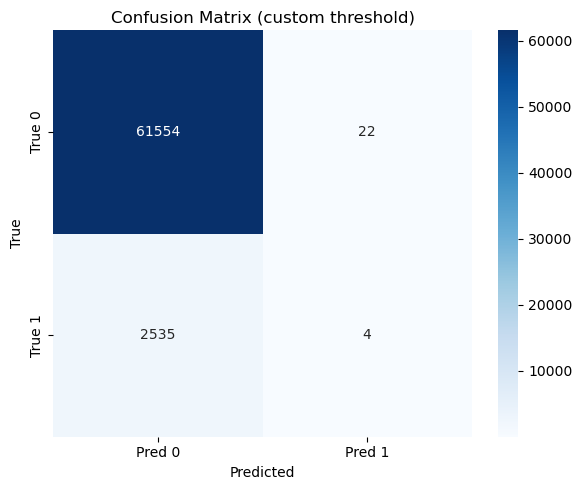

📊 Classification Report (custom threshold):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     61576
           1       0.15      0.00      0.00      2539

    accuracy                           0.96     64115
   macro avg       0.56      0.50      0.49     64115
weighted avg       0.93      0.96      0.94     64115

F1 Score: 0.0031189083820662767
Precision (positive class): 0.15384615384615385


In [16]:
# Trenowanie z najlepszymi parametrami
best_params = study.best_params
best_params["loss_function"] = "Logloss"
best_params["random_state"] = 42
best_params["verbose"] = 0

model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train)

# Predykcje prawdopodobieństw i dobór progu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Przewidujemy prawdopodobieństwa
y_probs = model.predict_proba(X_test)[:, 1]

# Przygotowanie do optymalizacji progu
thresholds = np.arange(0.1, 0.9, 0.01)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    results.append({'threshold': thresh, 'precision': precision, 'recall': recall, 'f1': f1})

# Konwertujemy wyniki do DataFrame
results_df = pd.DataFrame(results)

# Szukamy najlepszego progu
best_row = results_df.loc[results_df['f1'].idxmax()]
best_thresh = best_row['threshold']

#ponieważ działa to giga kiepsko
best_thresh = 0.17

print(f"\n🔍 Najlepszy threshold (na podstawie F1-score): {best_thresh:.2f}")
print(best_row)

# Rysujemy wykres
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], label='F1-score', linewidth=2)
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold ({best_thresh:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"✅ Best threshold: {best_thresh:.2f} with precision: {best_score:.3f}")

# Ostateczna predykcja z najlepszym thresholdem
y_pred_final = (y_probs >= best_thresh).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (custom threshold)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification report
print("📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_final, digits=2))

print("F1 Score:", f1_score(y_test, y_pred_final))
print("Precision (positive class):", precision_score(y_test, y_pred_final))


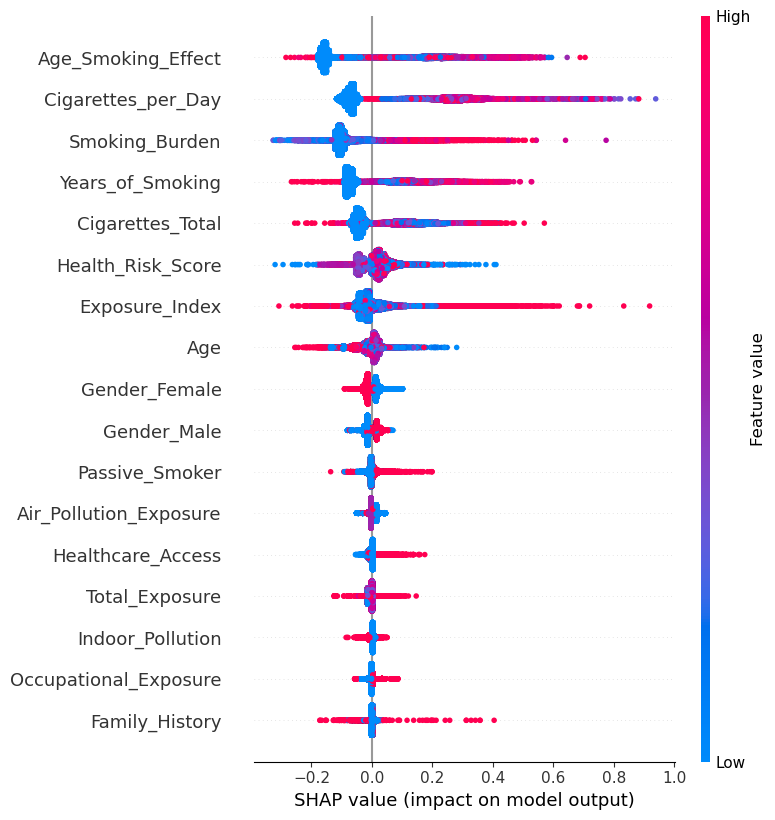

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wykres ogólny
shap.summary_plot(shap_values, X_test)

# Wykres dla pojedynczej próbki
# shap.plots.waterfall(explainer(X_test.iloc[0]))  # <-- odkomentuj dla konkretnej obserwacji
